In [1]:
import torch
import pickle
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.nn as gnn

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data

In [2]:
from net import PSOGNN
from pso import PSO 
from base_function import *

In [3]:
splited_path = r'A:\Code\deepso\splited_data_no.pkl'
with open(splited_path, 'rb') as f:
    dataset = pickle.load(f)

In [4]:
train_set = dataset['train']
test_set = dataset['test']
print(train_set[0])

{'dim': 1, 'func_type': 'ackley', 'params': [21.240033376567105, 0.20560771459870464, 7.294585386829872]}


In [5]:
def create_batches(dataset, batch_size): 
    random.shuffle(dataset)
    for i in range(0, len(dataset), batch_size): 
        batch = dataset[i:i + batch_size]
        yield batch

In [6]:
import torch
print(torch.cuda.is_available())  

True


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available() 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import time  # Import thêm module time

batch_size = 16
num_epochs = 10
UB = 1
LB = 0
num_particles = 100
padding_dim = 100

def save_model(model, optimizer, epoch, path="model_checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Model saved at epoch {epoch} to {path}")

def load_model(model, optimizer, path="model_checkpoint.pth"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Model loaded from {path}, resuming from epoch {epoch}")
    return epoch

def process_batch(func, num_particles, model, LB, UB, device, use_amp, accumulate_step, patience=5, scaler=None):
    dim = func['dim']
    func_type = func['func_type']
    params = func['params']
    
    def function(x):
        function_instance = Function.get_function(func_type, x, params)
        return function_instance.evaluate_function()

    X = torch.rand(num_particles, dim).to(device)
    
    # PSO without the epsilon parameter
    Pso = PSO(X, function, model, LB, UB, device=device, patience=patience)
    position_best, best, mean_fitness = Pso.run()

    if use_amp:
        with torch.cuda.amp.autocast():
            loss = mean_fitness
            loss = loss / accumulate_step  
            scaler.scale(loss).backward()
    else:
        loss = mean_fitness
        loss = loss / accumulate_step
        loss.backward()
    
    return func_type, loss.item()


def train(dataloader, accumulate_step, save_path="model_checkpoint.pth", use_amp=False, patience=5):
    epoch_losses = []
    batch_losses = {}
    function_losses = {}
    function_loss_ranges = {}

    max_norm = 1.0
    padding_dim = 100
    
    model = PSOGNN(node_input_dim=padding_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    total_start_time = time.time()  
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()  

        total_loss = 0
        batch_count = 0
        function_loader = create_batches(dataloader, batch_size)

        with ThreadPoolExecutor() as executor:
            futures = []
            for batch in function_loader:
                for func in batch:
                    futures.append(
                        executor.submit(
                            process_batch, func, num_particles, model, LB, UB, device, use_amp, accumulate_step, patience, scaler
                        )
                    )
            
            for future in as_completed(futures):
                func_type, loss = future.result()

                if func_type not in function_losses:
                    function_losses[func_type] = []
                function_losses[func_type].append(loss)

                total_loss += loss
                batch_count += 1

        avg_loss = total_loss / batch_count if batch_count > 0 else 0
        epoch_losses.append(avg_loss)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} seconds")

        scheduler.step(avg_loss)

        save_model(model, optimizer, epoch+1, save_path)

    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f"Training complete! Total training time: {total_training_time:.2f} seconds")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Average Loss over Epochs')
    plt.show()

    for func_type, losses in function_losses.items():
        min_loss = min(losses)
        max_loss = max(losses)
        function_loss_ranges[func_type] = (min_loss, max_loss)
        print(f"Function Type: {func_type}, Loss Range: Min={min_loss:.4f}, Max={max_loss:.4f}")

    return function_loss_ranges



Starting Training...
Epoch 1/10
Epoch 1/10, Loss: 26.2016, Time: 18272.13 seconds
Model saved at epoch 1 to model_checkpoint.pth
Epoch 2/10
Epoch 2/10, Loss: 26.3076, Time: 18106.18 seconds
Model saved at epoch 2 to model_checkpoint.pth
Epoch 3/10
Epoch 3/10, Loss: 26.2385, Time: 18561.54 seconds
Model saved at epoch 3 to model_checkpoint.pth
Epoch 4/10
Epoch 4/10, Loss: 26.3832, Time: 18480.78 seconds
Model saved at epoch 4 to model_checkpoint.pth
Epoch 5/10
Epoch 5/10, Loss: 26.3134, Time: 18149.44 seconds
Model saved at epoch 5 to model_checkpoint.pth
Epoch 6/10
Epoch 6/10, Loss: 26.2485, Time: 17677.28 seconds
Model saved at epoch 6 to model_checkpoint.pth
Epoch 7/10
Epoch 7/10, Loss: 26.2910, Time: 17687.47 seconds
Model saved at epoch 7 to model_checkpoint.pth
Epoch 8/10
Epoch 8/10, Loss: 26.2796, Time: 17835.25 seconds
Model saved at epoch 8 to model_checkpoint.pth
Epoch 9/10
Epoch 9/10, Loss: 26.3253, Time: 17854.61 seconds
Model saved at epoch 9 to model_checkpoint.pth
Epoch 1

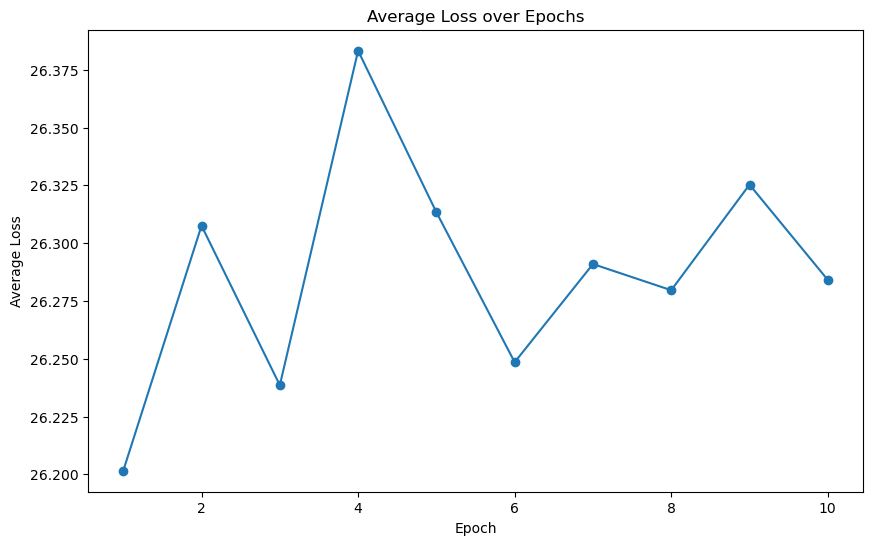

Function Type: levy, Loss Range: Min=0.0000, Max=2.4849
Function Type: ackley, Loss Range: Min=0.0000, Max=1.3885
Function Type: griewank, Loss Range: Min=0.0000, Max=0.1346
Function Type: rastrigin, Loss Range: Min=-0.0000, Max=539.1496
Function Type: buckin, Loss Range: Min=0.0039, Max=27.9132


In [9]:
accumulate_step = 4 

print("Starting Training...")
train_loss_ranges = train(train_set, accumulate_step, save_path="model_checkpoint.pth")


In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

def process_test_batch(func, num_particles, model, LB, UB, device):
    dim = func['dim']
    func_type = func['func_type']
    params = func['params']
    
    def function(x):
        function_instance = Function.get_function(func_type, x, params)
        return function_instance.evaluate_function()

    X = torch.rand(num_particles, dim).to(device)
    
    Pso = PSO(X, function, model, LB, UB, device=device, patience=5)
    position_best, best, mean_fitness = Pso.run()

    return func_type, mean_fitness.item()


def test(dataloader, model_path="model_checkpoint.pth"):
    model = PSOGNN(node_input_dim=padding_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    load_model(model, optimizer, model_path)
    model.eval()  

    test_losses = []
    function_losses = {}

    total_start_time = time.time()  

    function_loader = create_batches(dataloader, batch_size)

    with ThreadPoolExecutor() as executor:
        futures = []
        for batch in function_loader:
            for func in batch:
                futures.append(
                    executor.submit(
                        process_test_batch, func, num_particles, model, LB, UB, device
                    )
                )

        for future in as_completed(futures):
            func_type, loss = future.result()

            if func_type not in function_losses:
                function_losses[func_type] = []
            function_losses[func_type].append(loss)

            test_losses.append(loss)

    avg_test_loss = sum(test_losses) / len(test_losses) if len(test_losses) > 0 else 0


    total_end_time = time.time()
    total_test_time = total_end_time - total_start_time

    print(f"Testing complete! Average Test Loss: {avg_test_loss:.4f}")
    print(f"Total testing time: {total_test_time:.2f} seconds")

    plt.figure(figsize=(10, 6))
    plt.plot(test_losses, marker='o')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss per Batch on Test Set')
    plt.show()

    for func_type, losses in function_losses.items():
        min_loss = min(losses)
        max_loss = max(losses)
        print(f"Function Type: {func_type}, Loss Range: Min={min_loss:.4f}, Max={max_loss:.4f}")

    return avg_test_loss, function_losses


C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\1641046644.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Model loaded from model_checkpoint.pth, resuming from epoch 10
Testing complete! Average Test Loss: 104.8952
Total testing time: 8834.39 seconds


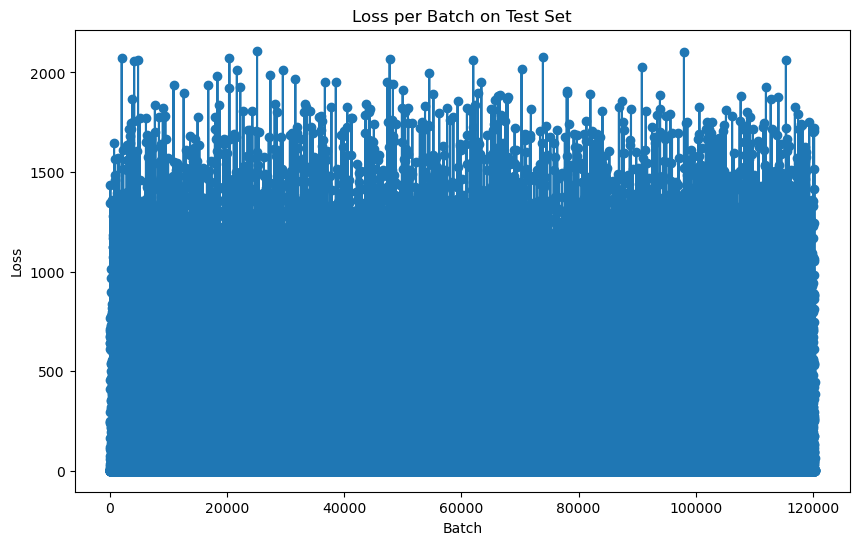

Function Type: rastrigin, Loss Range: Min=0.0000, Max=2108.9192
Function Type: ackley, Loss Range: Min=0.0000, Max=5.3450
Function Type: levy, Loss Range: Min=0.0000, Max=9.8806
Function Type: griewank, Loss Range: Min=0.0000, Max=0.5165
Function Type: buckin, Loss Range: Min=0.0507, Max=83.4973
Average Test Loss: 104.8952
Function Type: rastrigin, Loss Range: Min=0.0000, Max=2108.9192
Function Type: ackley, Loss Range: Min=0.0000, Max=5.3450
Function Type: levy, Loss Range: Min=0.0000, Max=9.8806
Function Type: griewank, Loss Range: Min=0.0000, Max=0.5165
Function Type: buckin, Loss Range: Min=0.0507, Max=83.4973


In [22]:
avg_test_loss, function_losses = test(test_set, model_path="model_checkpoint.pth")

print(f"Average Test Loss: {avg_test_loss:.4f}")

for func_type, losses in function_losses.items():
    min_loss = min(losses)
    max_loss = max(losses)
    print(f"Function Type: {func_type}, Loss Range: Min={min_loss:.4f}, Max={max_loss:.4f}")


Starting Training...
Epoch 1/10
Epoch 1/10, Loss: 26.2016, Time: 18272.13 seconds
Model saved at epoch 1 to model_checkpoint.pth
Epoch 2/10
Epoch 2/10, Loss: 26.3076, Time: 18106.18 seconds
Model saved at epoch 2 to model_checkpoint.pth
Epoch 3/10
Epoch 3/10, Loss: 26.2385, Time: 18561.54 seconds
Model saved at epoch 3 to model_checkpoint.pth
Epoch 4/10
Epoch 4/10, Loss: 26.3832, Time: 18480.78 seconds
Model saved at epoch 4 to model_checkpoint.pth
Epoch 5/10
Epoch 5/10, Loss: 26.3134, Time: 18149.44 seconds
Model saved at epoch 5 to model_checkpoint.pth
Epoch 6/10
Epoch 6/10, Loss: 26.2485, Time: 17677.28 seconds
Model saved at epoch 6 to model_checkpoint.pth
Epoch 7/10
Epoch 7/10, Loss: 26.2910, Time: 17687.47 seconds
Model saved at epoch 7 to model_checkpoint.pth
Epoch 8/10
Epoch 8/10, Loss: 26.2796, Time: 17835.25 seconds
Model saved at epoch 8 to model_checkpoint.pth
Epoch 9/10
Epoch 9/10, Loss: 26.3253, Time: 17854.61 seconds
Model saved at epoch 9 to model_checkpoint.pth
Epoch 10/10
Epoch 10/10, Loss: 26.2841, Time: 17961.30 seconds
Model saved at epoch 10 to model_checkpoint.pth
Training complete! Total training time: 180586.18 seconds
